# 量子蛋白质折叠

蛋白质折叠是蛋白质链从简单的氨基酸序列获得其功能性三维结构的物理过程。这种折叠是在氨基酸和周围环境之间的相互作用的引导下自发发生的，这决定了蛋白质的最终形状。正确的折叠对于蛋白质的功能至关重要，因为错误折叠可能导致阿尔茨海默氏症和帕金森氏症等疾病。

In [1]:
import matplotlib.lines as mlines
import dimod
import matplotlib.pyplot as plt
import dynex

In [8]:
# 蛋白质序列和网格尺寸
sequence = "PPHPPHP" # HP = 7

N = len(sequence)
L = (len(sequence) // 2) + 1  # 设定 5x5 网格

# 为每个网格点的每个珠子创建二进制变量（棋盘图案）
variables = {(i, j, k): f"x_{i}_{j}_{k}" for i in range(N) for j in range(L) for k in range(L)
             if (j + k) % 2 == i % 2}  # 基于珠索引的偶数/奇数站点放置

# 定义 HP 模型的交互矩阵
def interaction(h1, h2):
    return -1 if h1 == 'H' and h2 == 'H' else 0

# 初始化QUBO字典
Q = {}

# 添加 HP 能量术语
for f in range(N):
    for fp in range(f + 2, N):  # 确保按顺序排列不相邻
        if interaction(sequence[f], sequence[fp]) != 0:
            for j in range(L):
                for k in range(L):
                    for jp in range(L):
                        for kp in range(L):
                            if abs(j - jp) + abs(k - kp) == 1:  # 相邻的网格
                                if (j + k) % 2 == f % 2 and (jp + kp) % 2 == fp % 2:  # 正确的站点
                                    pair = (variables[f, j, k], variables[fp, jp, kp])
                                    if pair in Q:
                                        Q[pair] += interaction(sequence[f], sequence[fp])
                                    else:
                                        Q[pair] = interaction(sequence[f], sequence[fp])

# 确保每个珠子恰好放置在一个位置的约束
for i in range(N):
    for j in range(L):
        for k in range(L):
            if (j + k) % 2 == i % 2:
                one_site = [variables[i, jp, kp] for jp in range(L) for kp in range(L) if (jp + kp) % 2 == i % 2 and (jp, kp) != (j, k)]
                for var in one_site:
                    Q[(variables[i, j, k], var)] = Q.get((variables[i, j, k], var), 0) + 2  # 位于多个位置的二次惩罚

# 增强的自我回避约束
for j in range(L):
    for k in range(L):
        beads = [variables[i, j, k] for i in range(N) if (i, j, k) in variables]
        if len(beads) > 1:  # 仅当不止一个点可以占据该位置时才需要
            for b1 in range(len(beads)):
                for b2 in range(b1 + 1, len(beads)):
                    Q[(beads[b1], beads[b2])] = Q.get((beads[b1], beads[b2]), 0) + 10  # 显着增加重叠惩罚

# 添加连续节点之间的连接约束，并增加惩罚
for i in range(N - 1):
    for j in range(L):
        for k in range(L):
            if (j + k) % 2 == i % 2:  # 基于珠索引的偶数或奇数位点
                possible_next_positions = [(jp, kp) for jp in range(L) for kp in range(L)
                                           if abs(j - jp) + abs(k - kp) == 1 and (jp + kp) % 2 == (i + 1) % 2]
                if possible_next_positions:  # 确保有可能的职位
                    next_bead_vars = [variables[i + 1, jp, kp] for jp, kp in possible_next_positions]
                    # 如果不相邻，则施加更强的惩罚
                    for next_var in next_bead_vars:
                        Q[(variables[i, j, k], next_var)] = Q.get((variables[i, j, k], next_var), 0) - 3  # 吸引力为负



# 创建二元二次模型
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)

# ------------- Dynex -------------
model = dynex.BQM(bqm)
sampler = dynex.DynexSampler(model, mainnet=False, description='Quantum Protein Folding')
sampleset = sampler.sample(num_reads=1000, annealing_time=100, debugging=False)
print(sampleset)

lowest_energy_sample = sampleset.first.sample

# 从最低能量样本中的变量名称中提取珠子的位置
positions = {}
for variable_name, value in lowest_energy_sample.items():
    if value == 1:
        # 变量名格式为“x_i_j_k”，我们需要提取i,j,k
        parts = variable_name.split('_')
        i = int(parts[1])
        j = int(parts[2])
        k = int(parts[3])
        positions[i] = (j, k)

positions

[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬─────────────┬───────────┬───────────────────────────┬─────────┬─────────┬────────────────╮
│   DYNEXJOB │   BLOCK FEE │ ELAPSED   │ WORKERS READ              │ CHIPS   │ STEPS   │ GROUND STATE   │
├────────────┼─────────────┼───────────┼───────────────────────────┼─────────┼─────────┼────────────────┤
│         -1 │           0 │           │ *** WAITING FOR READS *** │         │         │                │
╰────────────┴─────────────┴───────────┴───────────────────────────┴─────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.00 SECONDS
[DYNEX] SAMPLESET READY
  x_0_0_0 x_0_0_2 x_0_1_1 x_0_1_3 x_0_2_0 x_0_2_2 ... x_6_3_3 energy num_oc.
0       0       0       0       0       0       0 ...       0  -28.0       1
['BINARY', 1 rows, 1 samples, 56 variables]


{0: (3, 3), 1: (3, 2), 2: (3, 1), 3: (2, 1), 4: (2, 0), 5: (1, 0), 6: (0, 0)}

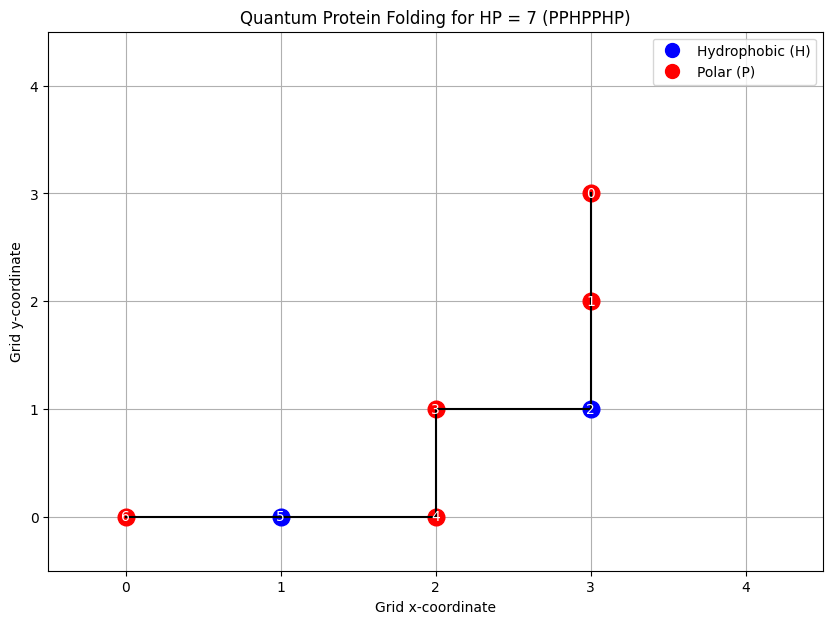

In [5]:
# 创建一个陷阱
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-0.5, 4.5)
ax.set_xticks(range(L+1))
ax.set_yticks(range(L+1))
ax.grid(True)

# 定义疏水性 (H) 和极性 (P) 珠子的颜色
colors = {'H': 'blue', 'P': 'red'}

# 绘制序列中的每个珠子并用线连接
for index in range(len(positions)):
    j, k = positions[index]
    color = colors[sequence[index]]
    ax.plot(j, k, 'o', markersize=12, color=color)  # 陷阱位置
    ax.text(j, k, f'{index}', color='white', ha='center', va='center')  # 标记点

    # 在连续的点之间画线
    if index > 0:
        prev_j, prev_k = positions[index - 1]
        ax.plot([prev_j, j], [prev_k, k], color='black') 
hydrophobic_legend = mlines.Line2D([], [], color='blue', marker='o',
                                   markersize=10, label='Hydrophobic (H)', linestyle='None')
polar_legend = mlines.Line2D([], [], color='red', marker='o',
                             markersize=10, label='Polar (P)', linestyle='None')
ax.legend(handles=[hydrophobic_legend, polar_legend])
ax.set_xlabel('Grid x-coordinate')
ax.set_ylabel('Grid y-coordinate')
ax.set_title('Quantum Protein Folding for HP = 7 ('+sequence+')')
plt.show()